# Analysis and testing

This notebooks contains the generation, analysis and visualisation of the data accompying Project 1 in FYS4411. Several tests and sanity-checks for the various methods are also included.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import src.analysis as src
from multiprocessing import Process, Queue
import pandas as pd
import time
from tqdm import tqdm

plt.gcf().subplots_adjust(bottom=0.15)
%load_ext autoreload
%autoreload 2

### Testing of blocking method:

For testing, we generate a time-series of random variables as $X_i = 0.5X_{i-1} + 0.5z$,  $z = N(0,1)$. Thus, each $X_i$ is normally distributed with mean 0 and variance 1, but is higly corrolated with the previous variables.

In [3]:
np.random.seed(42)
N= 2**18
X = [np.random.normal(0,1)]
for i in range(1, N):
    X.append(0.5*X[-1] + 0.5*np.random.normal(0,1))
X = np.array(X)

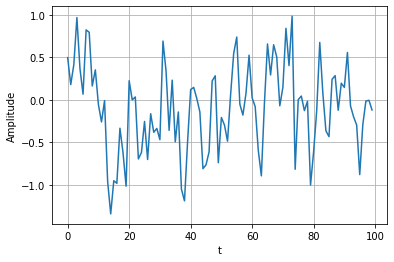

In [4]:
plt.plot(X[:100])
plt.xlabel("t")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

In [5]:
estimatedVar = src.blocking(X, degree = 10)

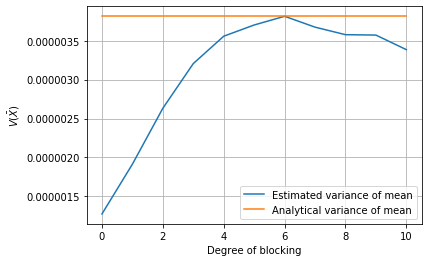

In [6]:
plt.plot(estimatedVar)
plt.plot((0,10), (1/N,1/N))
plt.xlabel("Degree of blocking")
plt.ylabel(r"$V(\bar{X})$")
plt.legend(["Estimated variance of mean", "Analytical variance of mean"])
plt.grid()
plt.show()

### One body density for 1 particle, 1 dimmension. Comparing Bruteforce Sampling with Importance Sampling

In [7]:
conf = src.config()
conf["numPart"] = 1
conf["numDim"] = 1
conf["numSteps"] = 1000000
conf["stepLength"] = 0.5
conf["importanceSampling"] = 0 #using bruteforce sampling

conf["alpha"] = 0.5
conf["omega"] = 1

conf["InitialState"] = "RandomUniform"
conf["Wavefunction"] = "SimpleGaussian"
conf["Hamiltonian"] = "HarmonicOscillator"

In [8]:
src.runner(conf)
_, posBruteForce, _, _ = src.readData(conf)

conf["importanceSampling"] = 1  #switching to importance sampling
src.runner(conf)
_, posImportance, _, _ = src.readData(conf)

Calculating and plotting the densities:

In [9]:
bins = np.linspace(-3, 3, 200)
dx = bins[1] - bins[0]
densityBruteForce = src.oneBodyDensity(posBruteForce[0], bins, mode = "1D")/conf["numSteps"]
densityImportance = src.oneBodyDensity(posImportance[0], bins, mode = "1D")/conf["numSteps"]

100%|██████████| 1000000/1000000 [00:03<00:00, 312512.27it/s]


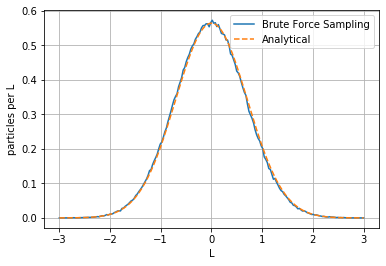

/home/kristian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  app.launch_new_instance()


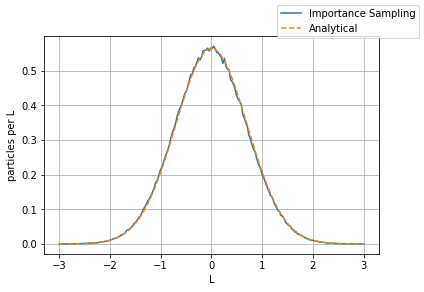

In [15]:
fig = plt.figure()
plt.plot(bins, densityBruteForce)
plt.plot(bins, 1/np.sqrt(np.pi)*np.exp(-bins**2), "--")
plt.xlabel("L")
plt.ylabel("particles per L")
plt.legend(["Brute Force Sampling", "Analytical"])
plt.grid()
plt.show()
fig.savefig("figures/density1.pdf")

fig = plt.figure()
plt.plot(bins, densityImportance)
plt.plot(bins, 1/np.sqrt(np.pi)*np.exp(-bins**2), "--")
plt.xlabel("L")
plt.ylabel("particles per L")
fig.legend(["Importance Sampling", "Analytical"])
plt.grid()
plt.show()
fig.savefig("figures/density2.pdf")


### Radial one body density for 2 particle, 3 dimmension. Comparing Bruteforce Sampling with Importance sampling

In [80]:
conf = src.config()
conf["numPart"] = 2
conf["numDim"] = 3
conf["numSteps"] = 1000000
conf["stepLength"] = 0.5
conf["importanceSampling"] = 0 #using bruteforce sampling

conf["alpha"] = 0.5
conf["omega"] = 1

conf["InitialState"] = "RandomUniform"
conf["Wavefunction"] = "SimpleGaussian"
conf["Hamiltonian"] = "HarmonicOscillator"

In [81]:
src.runner(conf)
_, posBruteForce, _, _ = src.readData(conf)

conf["importanceSampling"] = 1  #switching to importance sampling
src.runner(conf)
_, posImportance, _, _ = src.readData(conf)

In [82]:
bins = np.linspace(0, 3, 200)
dx = bins[1] - bins[0]
densityBruteForce = src.oneBodyDensity(posBruteForce[0].reshape(-1,conf["numDim"]), bins)/conf["numSteps"]
densityImportance = src.oneBodyDensity(posImportance[0].reshape(-1,conf["numDim"]), bins)/conf["numSteps"]

100%|██████████| 2000000/2000000 [00:01<00:00, 1078238.48it/s]


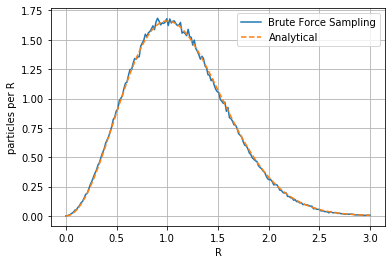

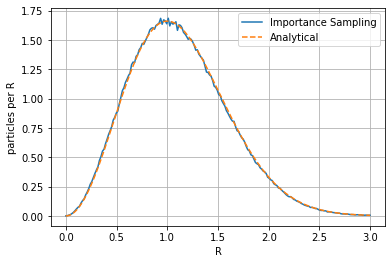

In [83]:
fig = plt.figure()
plt.plot(bins, densityBruteForce)
plt.plot(bins, 2*4/np.sqrt(np.pi)*np.exp(-bins**2)*bins**2, "--")
plt.xlabel("R")
plt.ylabel("particles per R")
plt.legend(["Brute Force Sampling", "Analytical"])
plt.grid()
plt.show()
fig.savefig("figures/density3.pdf")

fig = plt.figure()
plt.plot(bins, densityImportance)
plt.plot(bins, 2*4/np.sqrt(np.pi)*np.exp(-bins**2)*bins**2, "--")
plt.xlabel("R")
plt.ylabel("particles per R")
plt.legend(["Importance Sampling", "Analytical"])
plt.grid()
plt.show()
fig.savefig("figures/density4.pdf")

### Local Energy for various $\alpha$, for 2 particles, 3 dimmensions in harmonic oscillator. Brute force and importance sampling are used and checked against analytical results to verify the methods works correctly in higher dimmension.

#### Brute force sampling:

In [6]:
conf = src.config()
conf["numPart"] = 2
conf["numDim"] = 3
conf["numSteps"] = 2**17
conf["stepLength"] = 0.8
conf["importanceSampling"] = 0 #using bruteforce sampling

conf["omega"] = 1

conf["InitialState"] = "RandomUniform"
conf["Wavefunction"] = "SimpleGaussian"
conf["Hamiltonian"] = "HarmonicOscillator"

In [7]:
x = np.linspace(0.3, 0.8, 11)
E = []
E_var = []
Var = []
for alpha in tqdm(x):
    conf["alpha"] = alpha
    src.runner(conf)
    localEnergies, _, _, acceptanceRate = src.readData(conf)
    E.append(np.mean(localEnergies[0]))
    E_var.append(np.std(localEnergies[0])**2)
    Var.append(src.blocking(localEnergies[0], degree=15))
print("Done!")
print(f"Acceptance Rate: {acceptanceRate[0]}")

100%|██████████| 11/11 [00:11<00:00,  1.04s/it]

Done!
Acceptance Rate: 0.5003890000000001


#### Checking appropriate degree of blocking

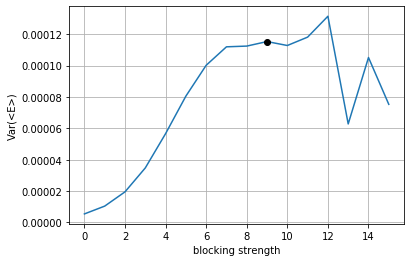

In [8]:
fig = plt.figure()
fig.tight_layout()
plt.plot(Var[-1])
plt.plot(9, Var[-1][9], "ko")
plt.xlabel("blocking strength")
plt.ylabel("Var(<E>)")
plt.grid()

plt.show()
fig.savefig("figures/blocking1.pdf", bbox_inches = "tight")

#### Plotting estimated energy as a function of alpha for 2 paricles in 3 dimmensions, harmonic oscillator:

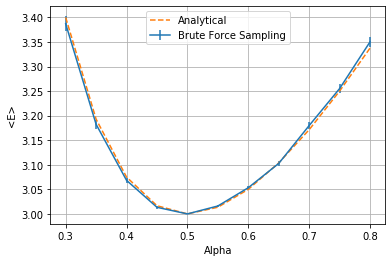

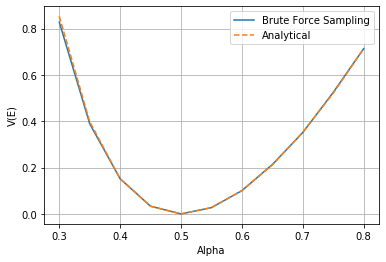

In [9]:
E = np.array(E)
E_var = np.array(E_var)
Var = np.array(Var)
std = np.sqrt(Var[:,9])

fig = plt.figure()
plt.errorbar(x, E, std)
plt.plot(x, 6*(1/(8*x) + 1/2*x), "--")
plt.xlabel("Alpha")
plt.ylabel("<E>")
plt.legend([ "Analytical","Brute Force Sampling"])
plt.grid()
plt.show()
fig.savefig("figures/energy_bruteforce1.pdf", bbox_inches = "tight")

fig = plt.figure()
plt.plot(x, E_var)
plt.plot(x, 6*(0.25 + 3*(1/(8*x) - 0.5*x)**2 - (1/(8*x) + 0.5*x)**2), "--")
plt.xlabel("Alpha")
plt.ylabel("V(E)")
plt.legend(["Brute Force Sampling",  "Analytical"])
plt.grid()
plt.show()
fig.savefig("figures/variance_bruteforce1.pdf", bbox_inches = "tight")

#### Importance Sampling:

In [16]:
conf = src.config()
conf["numPart"] = 2
conf["numDim"] = 3
conf["numSteps"] = 2**17
conf["stepLength"] = 0.5
conf["importanceSampling"] = 1 #using importance sampling

conf["omega"] = 1

conf["InitialState"] = "RandomUniform"
conf["Wavefunction"] = "SimpleGaussian"
conf["Hamiltonian"] = "HarmonicOscillator"

In [17]:
x = np.linspace(0.3, 0.8, 11)
E = []
E_var = []
Var = []

for alpha in tqdm(x):
    conf["alpha"] = alpha
    src.runner(conf)
    localEnergies, _, _, acceptanceRate = src.readData(conf)
    E.append(np.mean(localEnergies[0]))
    E_var.append(np.std(localEnergies[0])**2)
    Var.append(src.blocking(localEnergies[0], degree=15))
print("Done!")
print(f"Acceptance Rate: {acceptanceRate[0]}")

100%|██████████| 11/11 [00:11<00:00,  1.05s/it]

Done!
Acceptance Rate: 0.691666


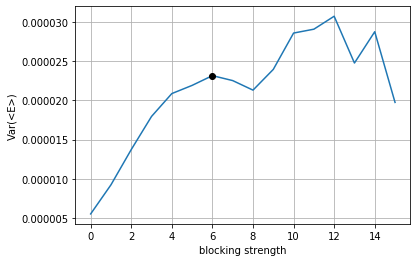

In [18]:
fig = plt.figure()
plt.plot(Var[-1])
plt.plot(6, Var[-1][6], "ko")
plt.xlabel("blocking strength")
plt.ylabel("Var(<E>)")
plt.grid()
plt.show()

fig.savefig("figures/blocking2.pdf", bbox_inches = "tight")

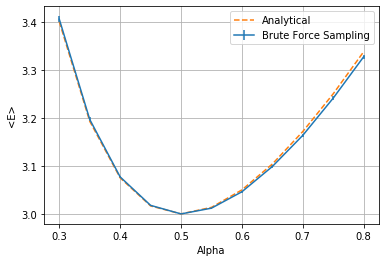

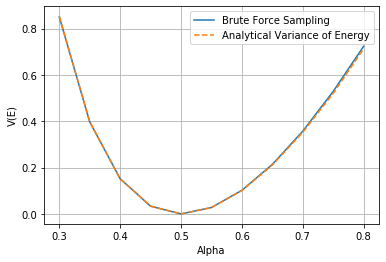

In [19]:
E = np.array(E)
Var = np.array(Var)
std = np.sqrt(Var[:,8])

fig = plt.figure()
plt.errorbar(x, E, std)
plt.plot(x, 6*(1/(8*x) + 1/2*x), "--")
plt.xlabel("Alpha")
plt.ylabel("<E>")
plt.legend([ "Analytical","Brute Force Sampling"])
plt.grid()
plt.show()
fig.savefig("figures/energy_importance1.pdf", bbox_inches = "tight")


fig = plt.figure()
plt.plot(x, E_var)
plt.plot(x, 6*(0.25 + 3*(1/(8*x) - 0.5*x)**2 - (1/(8*x) + 0.5*x)**2), "--")
plt.xlabel("Alpha")
plt.ylabel("V(E)")
plt.legend(["Brute Force Sampling",  "Analytical Variance of Energy"])
plt.grid()
plt.show()
fig.savefig("figures/variance_importance1.pdf", bbox_inches = "tight")

### Repeated analysis for 40 particles

#### Brute Force

In [22]:
conf = src.config()
cutoff = 2000
conf["numPart"] = 40
conf["numDim"] = 3
conf["numSteps"] = 2**20 + cutoff
conf["stepLength"] = 1.2
conf["importanceSampling"] = 0 #using bruteforce sampling

conf["alpha"] = 0.3
conf["omega"] = 1

conf["InitialState"] = "RandomUniform"
conf["Wavefunction"] = "SimpleGaussian"
conf["Hamiltonian"] = "HarmonicOscillator"

In [23]:
src.runner(conf, verbose = True)
localEnergies, _, _, acceptanceRate = src.readData(conf)
E = np.mean(localEnergies[0][cutoff:])
Var = src.blocking(localEnergies[0][cutoff:], degree=18)
print(f"Acceptance Rate: {acceptanceRate[0]}")

Starting simulation
numPart: 40
numDim: 3
numSteps: 1050576
stepLength: 1.2
importanceSampling: 0
alpha: 0.3
a: 1
omega: 1
InitialState: RandomUniform
WaveFunction: SimpleGaussian
Hamiltonian: HarmonicOscillator
Done!
------------
Acceptance Rate: 0.534333


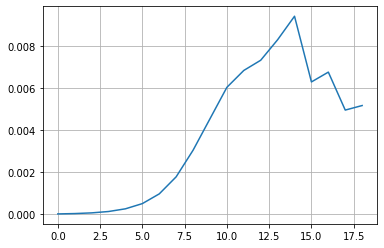

In [24]:
plt.plot(Var)
plt.grid()
plt.show()

In [25]:
std = np.sqrt(Var[13])
a = conf["alpha"]
E_analytical = 3*40*(1/(8*a) + 1/2*a)

print(f"Numerical: <E> = {E} +- {std}")
print(f"Analytical: <E> = {E_analytical}")

Numerical: <E> = 68.06431683397294 +- 0.09104741323267279
Analytical: <E> = 68.0


#### Importance Sampling

In [3]:
conf = src.config()
cutoff = 2000
conf["numPart"] = 40
conf["numDim"] = 3
conf["numSteps"] = 2**20 + cutoff
conf["importanceSampling"] = 1 #importance sampling

conf["alpha"] = 0.3
conf["omega"] = 1

conf["InitialState"] = "RandomUniform"
conf["Wavefunction"] = "SimpleGaussian"
conf["Hamiltonian"] = "HarmonicOscillator"

In [4]:
conf["stepLength"] = 0.5
src.runner(conf)
localEnergies1, _, _, acceptanceRate1 = src.readData(conf)
E1 = np.mean(localEnergies1[0][cutoff:])
Var1 = src.blocking(localEnergies1[0][cutoff:], degree=18)
print(f"Step length: {conf['stepLength']}. Acceptance rate: {acceptanceRate1}")

conf["stepLength"] = 1
src.runner(conf)
localEnergies2, _, _, acceptanceRate2 = src.readData(conf)
E2 = np.mean(localEnergies2[0][cutoff:])
Var2 = src.blocking(localEnergies2[0][cutoff:], degree=18)
print(f"Step length: {conf['stepLength']}. Acceptance rate: {acceptanceRate2}")
      
conf["stepLength"] = 2
src.runner(conf)
localEnergies3, _, _, acceptanceRate3 = src.readData(conf)
E3 = np.mean(localEnergies3[0][cutoff:])
Var3 = src.blocking(localEnergies3[0][cutoff:], degree=18)
print(f"Step length: {conf['stepLength']}. Acceptance rate: {acceptanceRate3}")



100%|██████████| 18/18 [00:04<00:00,  4.04it/s]


Step length: 0.5. Acceptance rate: [0.926632]


100%|██████████| 18/18 [00:04<00:00,  4.12it/s]


Step length: 1. Acceptance rate: [0.795079]


100%|██████████| 18/18 [00:04<00:00,  4.21it/s]

Step length: 2. Acceptance rate: [0.478895]


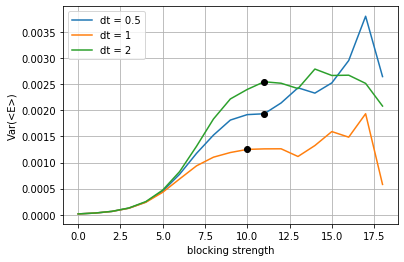

In [5]:
fig = plt.figure()
plt.plot(Var1)
plt.plot(Var2)
plt.plot(Var3)
plt.plot(11, Var1[11], "ko")
plt.plot(10, Var2[10], "ko")
plt.plot(11, Var3[11], "ko")

plt.legend(["dt = 0.5", "dt = 1", "dt = 2"])
plt.xlabel("blocking strength")
plt.ylabel("Var(<E>)")
plt.grid()
plt.show()
fig.savefig("figures/blocking3.pdf", bbox_inches = "tight")

In [29]:
std1 = np.sqrt(Var1[11])
std2 = np.sqrt(Var2[10])
std3 = np.sqrt(Var3[11])
a = conf["alpha"]
E_analytical = 3*40*(1/(8*a) + 1/2*a)

print(f"dt = 0.5: <E> = {E1} +- {std1}")
print(f"dt = 1: <E> = {E2} +- {std2}")
print(f"dt = 2: <E> = {E3} +- {std3}")
print(f"Analytical: <E> = {E_analytical}")

dt = 0.5: <E> = 68.0090111966133 +- 0.043963612917920565
dt = 1: <E> = 68.03935787248612 +- 0.03536702229873993
dt = 2: <E> = 67.94214192819595 +- 0.05045206659678679
Analytical: <E> = 68.0


### Repeated analysis for numerically calculated laplacian

In [24]:
conf = src.config()
conf["numPart"] = 2
conf["numDim"] = 3
conf["numSteps"] = 2**17
conf["stepLength"] = 0.5
conf["importanceSampling"] = 0

conf["alpha"] = 0.5
conf["omega"] = 1

conf["InitialState"] = "RandomUniform"
conf["Wavefunction"] = "SimpleGaussianNumerical" #numerical laplacian
conf["Hamiltonian"] = "HarmonicOscillator"

In [25]:
x = np.linspace(0.3, 0.8, 21)
E = []
Var = []
for alpha in x:
    conf["alpha"] = alpha
    src.runner(conf)
    localEnergies, _, _, acceptanceRate = src.readData(conf)
    E.append(np.mean(localEnergies[0]))
    Var.append(src.blocking(localEnergies[0], degree=15))
print("Done!")
print(f"Acceptance Rate: {acceptanceRate[0]}")

100%|██████████| 15/15 [00:00<00:00, 26.88it/s]

Done!
Acceptance Rate: 0.6701050000000001


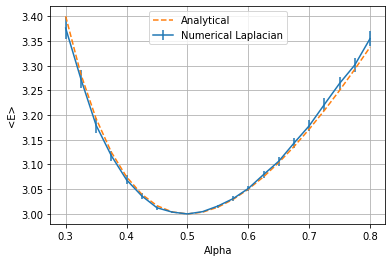

In [27]:
E = np.array(E)
Var = np.array(Var)
std = np.sqrt(Var[:,13])

fig= plt.figure()
plt.errorbar(x, E, std)
plt.plot(x, 6*(1/(8*x) + 1/2*x), "--")
plt.xlabel("Alpha")
plt.ylabel("<E>")
plt.legend([ "Analytical","Numerical Laplacian"])

plt.grid()
plt.show()
fig.savefig("figures/numericalLap.pdf", bbox_inches = "tight")

#### CPU-time differences between analytical and numerical laplacian

In [22]:
conf = src.config()
conf["numDim"] = 3
conf["stepLength"] = 1
conf["importanceSampling"] = 0

conf["alpha"] = 0.5
conf["omega"] = 1

conf["InitialState"] = "RandomUniform"
conf["Hamiltonian"] = "HarmonicOscillator"

In [23]:
timeAnalytic = []
timeNumeric = []
cycles = 4000000
N = np.array([1, 3, 10, 30, 100, 300])
for n in tqdm(N):
    conf["numDim"] = n
    conf["numSteps"] = cycles/n
    conf["Wavefunction"] = "SimpleGaussian"
    
    start = time.time()
    src.runner(conf)
    end = time.time()
    timeAnalytic.append((end - start)/conf["numSteps"])
    
    conf["Wavefunction"] = "SimpleGaussianNumerical"
    
    start = time.time()
    src.runner(conf)
    end = time.time()
    timeNumeric.append((end - start)/conf["numSteps"])

100%|██████████| 6/6 [00:27<00:00,  4.58s/it]


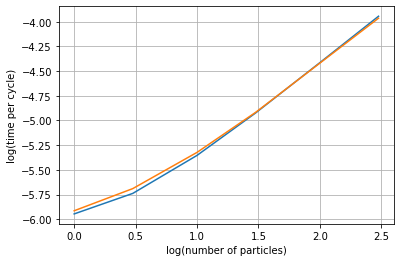

[1.1306896805763245e-06, 1.8251363039016725e-06, 4.430502057075501e-06, 1.1934732198715209e-05, 3.860480785369873e-05, 0.00011388992071151733]
[1.2171247005462647e-06, 2.0416519045829775e-06, 4.753182530403137e-06, 1.2101633548736571e-05, 3.8175231218338014e-05, 0.00010883029103279113]


In [30]:
fig = plt.figure()
plt.plot(np.log10(N), np.log10(timeAnalytic))
plt.plot(np.log10(N), np.log10(timeNumeric))
plt.xlabel("log(number of particles)")
plt.ylabel("log(time per cycle)")

plt.grid()
plt.show()
fig.savefig("figures/numericalTime.pdf", bbox_inches = "tight")

### Thermalization of many particals, using Brute Force Sampling and Importance Sampling

In [33]:
conf = src.config()
conf["numDim"] = 3
conf["numSteps"] = 10000
conf["stepLength"] = 1
conf["importanceSampling"] = 0 #importance sampling

conf["alpha"] = 0.3
conf["omega"] = 1

conf["InitialState"] = "RandomUniform"
conf["Wavefunction"] = "SimpleGaussian"
conf["Hamiltonian"] = "HarmonicOscillator"

In [34]:
conf["numPart"] = 1
src.runner(conf)
localEnergies1, _, _, acceptanceRate = src.readData(conf)
print(acceptanceRate[0])

conf["numPart"] = 10
src.runner(conf)
localEnergies2, _, _, acceptanceRate = src.readData(conf)
print(acceptanceRate[0])

conf["numPart"] = 20
src.runner(conf)
localEnergies3, _, _, acceptanceRate = src.readData(conf)
print(acceptanceRate[0])

conf["numPart"] = 100
src.runner(conf)
localEnergies4, _, _, acceptanceRate = src.readData(conf)
print(acceptanceRate[0])

0.5962
0.6036
0.6086
0.6008


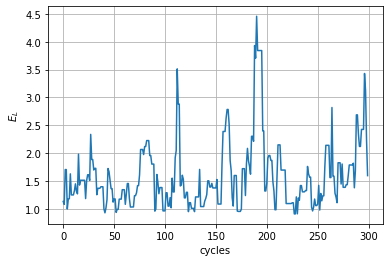

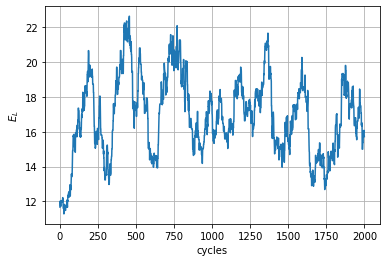

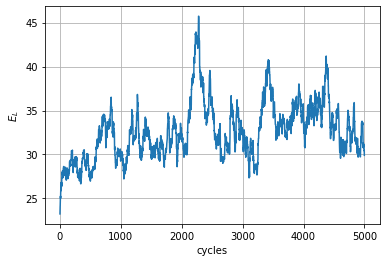

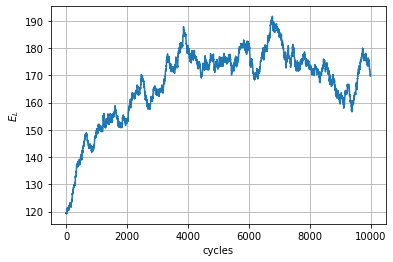

In [35]:
plt.plot(localEnergies1[0][:300])
plt.xlabel("cycles")
plt.ylabel("$E_L$")
plt.grid()
plt.show()

plt.plot(localEnergies2[0][:2000])
plt.xlabel("cycles")
plt.ylabel("$E_L$")
plt.grid()
plt.show()

plt.plot(localEnergies3[0][:5000])
plt.xlabel("cycles")
plt.ylabel("$E_L$")
plt.grid()
plt.show()

plt.plot(localEnergies4[0])
plt.xlabel("cycles")
plt.ylabel("$E_L$")
plt.grid()
plt.show()

In [36]:
conf["numPart"] = 100
conf["importanceSampling"] = 1
conf["stepLength"] = 1.6
src.runner(conf, verbose = True)
localEnergies, _, _, acceptanceRate = src.readData(conf)
print(f"Acceptance Rate: {acceptanceRate}")

Starting simulation
numPart: 100
numDim: 3
numSteps: 10000
stepLength: 1.6
importanceSampling: 1
alpha: 0.3
a: 1
omega: 1
InitialState: RandomUniform
WaveFunction: SimpleGaussian
Hamiltonian: HarmonicOscillator
Done!
------------
Acceptance Rate: [0.5954]


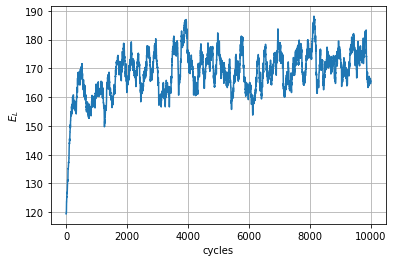

In [37]:
plt.plot(localEnergies[0])
plt.xlabel("cycles")
plt.ylabel("$E_L$")
plt.grid()
plt.show()

### One-body density for two interacting particles in 1D, harmonic oscillator

In [54]:
conf = src.config()
conf["numPart"] = 2
conf["numDim"] = 1
conf["numSteps"] = 4000000
conf["stepLength"] = 0.1
conf["importanceSampling"] = 1

conf["alpha"] = 0.5
conf["omega"] = 1

conf["InitialState"] = "HardshellInitial"
conf["Wavefunction"] = "HardshellWavefunction"
conf["Hamiltonian"] = "HarmonicOscillator"

In [55]:
conf["a"] = 0
src.runner(conf)
_, posNoninteracting, _, acceptanceRate = src.readData(conf)
print(f"Acceptance Rate: {acceptanceRate}")

conf["a"] = 1
src.runner(conf)
_, posInteracting, _, acceptanceRate = src.readData(conf)
print(f"Acceptance Rate: {acceptanceRate}")

conf["numPart"] = 3
src.runner(conf)
_, posInteracting3Part, _, acceptanceRate = src.readData(conf)
print(f"Acceptance Rate: {acceptanceRate}")

Acceptance Rate: [0.992813]
Acceptance Rate: [0.739142]
Acceptance Rate: [0.55156]


In [56]:
bins = np.linspace(-3, 3, 200)
densityNoninteracting = src.oneBodyDensity(posNoninteracting[0], bins, mode = "1D")/conf["numSteps"]
densityInteracting = src.oneBodyDensity(posInteracting[0], bins, mode = "1D")/conf["numSteps"]
densityInteracting3Part = src.oneBodyDensity(posInteracting3Part[0], bins, mode = "1D")/conf["numSteps"]

100%|██████████| 12000000/12000000 [00:39<00:00, 304360.02it/s]


#### Non-interacting

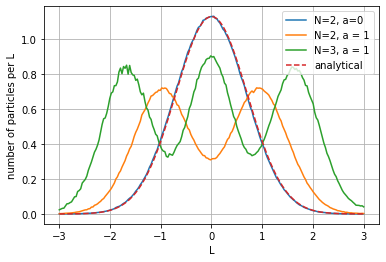

In [57]:
fig = plt.figure()
plt.plot(bins, densityNoninteracting)
plt.plot(bins, densityInteracting)
plt.plot(bins, densityInteracting3Part)
plt.plot(bins, 2/np.sqrt(np.pi)*np.exp(-bins**2), "--")
plt.legend(["N=2, a=0", "N=2, a = 1", "N=3, a = 1", "analytical"])
plt.xlabel("L")
plt.ylabel("number of particles per L")
plt.grid()
plt.show()
fig.savefig("figures/interactingDensity.pdf", bbox_inches = "tight")

#### Interacting

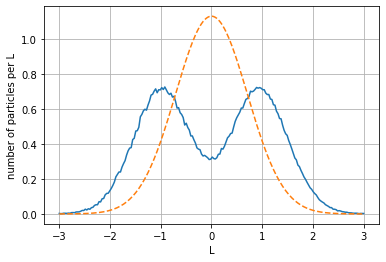

In [45]:
plt.plot(bins, densityInteracting)
plt.plot(bins, 2/np.sqrt(np.pi)*np.exp(-bins**2), "--")
plt.xlabel("L")
plt.ylabel("number of particles per L")
plt.grid()
plt.show()

#### Three interacting particles

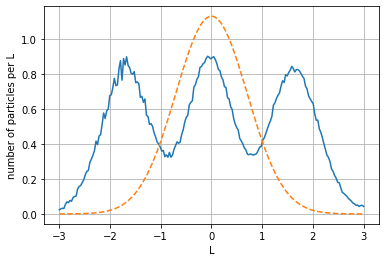

In [46]:
plt.plot(bins, densityInteracting3Part)
plt.plot(bins, 2/np.sqrt(np.pi)*np.exp(-bins**2), "--")
plt.xlabel("L")
plt.ylabel("number of particles per L")
plt.grid()
plt.show()

### One-body density of many interacting particles in 2D

#### Non-interacting

In [47]:
conf = src.config()
conf["directory"] = "data1"
conf["threads"] = 8
conf["numPart"] = 10
conf["numDim"] = 2
conf["numSteps"] = 1000000
conf["stepLength"] = 0.5
conf["alpha"] = 0.4
conf["a"] = 1
conf["omega"] = 1

src.runner(conf, verbose = True)

Starting simulation
numPart: 10
numDim: 2
numSteps: 1000000
stepLength: 0.5
importanceSampling: 0
alpha: 0.4
a: 1
omega: 1
InitialState: RandomUniform
WaveFunction: SimpleGaussian
Hamiltonian: HarmonicOscillator
Done!
------------


In [48]:
r = np.linspace(-5, 5, 200)


def f(q,i):
    pos = pd.read_csv(f"data1/configuration_{i}.txt", sep ="\n", header = None).values.reshape(-1,2)
    density = src.oneBodyDensity(pos, r, mode = "2D")
    q.put(density)
    
q = Queue()
    
processes = [Process(target = f, args=(q,i)) for i in range(conf["threads"])]

for p in processes:
    p.start()
 

density = q.get()
for i in range(conf["threads"]-1):
    density += q.get()

density /= conf["threads"]

100%|██████████| 10000000/10000000 [00:22<00:00, 449701.92it/s]


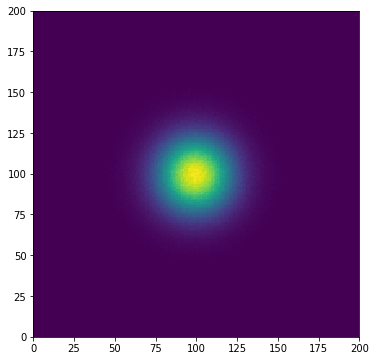

In [49]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
ax.set_aspect("equal")
ax.pcolormesh(density)
plt.show()

#### Interacting

In [50]:
conf = src.config()
conf["directory"] = "data2"
conf["threads"] = 8
conf["numPart"] = 10
conf["numDim"] = 2
conf["numSteps"] = 1000000
conf["stepLength"] = 0.01
conf["importanceSampling"] = 1
conf["alpha"] = 0.5
conf["a"] = 0.7
conf["omega"] = 1

conf["InitialState"] = "HardshellInitial"
conf["Wavefunction"] = "HardshellWavefunction"
conf["Hamiltonian"] = "HarmonicOscillator"

src.runner(conf, verbose = True)

Starting simulation
numPart: 10
numDim: 2
numSteps: 1000000
stepLength: 0.01
importanceSampling: 1
alpha: 0.5
a: 0.7
omega: 1
InitialState: HardshellInitial
WaveFunction: HardshellWavefunction
Hamiltonian: HarmonicOscillator
Done!
------------


In [51]:
r = np.linspace(-5, 5, 200)


def f(q,i):
    pos = pd.read_csv(f"data2/configuration_{i}.txt", sep ="\n", header = None).values.reshape(-1,2)
    density = src.oneBodyDensity(pos, r, mode = "2D")
    q.put(density)
    
q = Queue()
    
processes = [Process(target = f, args=(q,i)) for i in range(conf["threads"])]

for p in processes:
    p.start()
 

density = q.get()
for i in range(conf["threads"]-1):
    density += q.get()

density /= conf["threads"]

100%|██████████| 10000000/10000000 [00:22<00:00, 438340.82it/s]


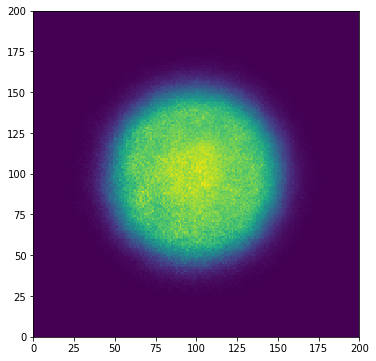

In [52]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
ax.set_aspect("equal")
ax.pcolormesh(density)
plt.show()

### Gradient decent

In [58]:
conf = src.config()
conf["numPart"] = 2
conf["numDim"] = 3
conf["numSteps"] = 10000
conf["stepLength"] = 1
conf["importanceSampling"] = 1
conf["omega"] = 1

conf["alpha"] = 0.4

conf["InitialState"] = "RandomUniform"
conf["Wavefunction"] = "SimpleGaussian"
conf["Hamiltonian"] = "HarmonicOscillator"

alphaArray = []
mu = 0.01

for i in range(30):
    src.runner(conf)
    localEnergies, _, psiGrad, _ = src.readData(conf)
    grad = src.calculateGradient(localEnergies, psiGrad)

    conf["alpha"] -= mu*grad
    alphaArray.append(conf["alpha"])

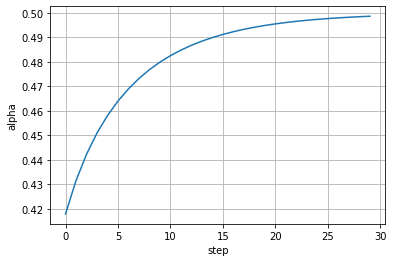

In [59]:
fig = plt.figure()
plt.plot(alphaArray)
plt.xlabel("step")
plt.ylabel("alpha")
plt.grid()
plt.show()
fig.savefig("figures/gd.pdf", bbox_inches = "tight")

### Elliptical Trap

### 10 Particles

In [15]:
conf = src.config()
cutoff = 500

conf["directory"] = "elliptical_10_interacting"
conf["threads"] = 12

conf["numPart"] = 10
conf["numDim"] = 3
conf["numSteps"] = 2**18 + cutoff
conf["stepLength"] = 0.5
conf["importanceSampling"] = 1

conf["alpha"] = 0.5
conf["a"] = 0.0043

conf["InitialState"] = "HardshellInitial"
conf["Wavefunction"] = "EllipticalHardshellWavefunction"
conf["Hamiltonian"] = "EllipticalOscillator"

#### Gradient decent

In [ ]:
mu = 0.01

for i in range(5):
    src.runner(conf)
    localEnergies, _, psiGrad, acceptanceRate = src.readData(conf)
    gradient = src.calculateGradient(localEnergies, psiGrad)
    conf["alpha"] -= mu*gradient
    print(f"gradient: {gradient:.5f}. alpha: {conf['alpha']:.5f}. acceptance rate: {acceptanceRate[0]:.5f}.")

#### Using optimal alpha

In [89]:
conf["alpha"] = 0.497521414211705
conf["numSteps"] = 2**20 + cutoff
src.runner(conf, verbose = True)

Starting simulation
numPart: 10
numDim: 3
numSteps: 1049076
stepLength: 0.5
importanceSampling: 1
alpha: 0.497521414211705
a: 0.0043
omega: 1
InitialState: HardshellInitial
WaveFunction: EllipticalHardshellWavefunction
Hamiltonian: EllipticalOscillator
Done!
------------


In [17]:
#localEnergies, _, psiGrad, acceptanceRate = src.readData(conf, cutoff, readPos = False)
#localEnergies = np.concatenate(localEnergies)

bins = np.linspace(0, 3, 200)
densityInteracting = src.densityParallel(conf, bins)/conf["numSteps"]

100%|██████████| 10490760/10490760 [00:13<00:00, 769092.63it/s]


In [18]:
conf["directory"] = "elliptical_10_noninteracting"
conf["a"] = 0 

In [ ]:
src.runner(conf, verbose = True)

In [19]:
bins = np.linspace(0, 3, 200)
densityNonInteracting = src.densityParallel(conf, bins)/conf["numSteps"]

100%|██████████| 10490760/10490760 [00:12<00:00, 825327.84it/s]

100%|██████████| 10490760/10490760 [00:13<00:00, 787429.34it/s]


#### Estimation of energy and uncertainty

In [94]:
E = np.mean(localEnergies)
Var = src.blocking(localEnergies, 18)

100%|██████████| 18/18 [00:52<00:00,  2.93s/it]


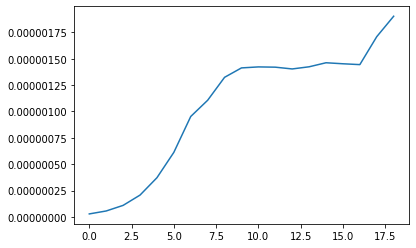

In [95]:
plt.plot(Var)
plt.show()

In [96]:
print(f"<E> = {E} +- {np.sqrt(Var[9])}")

<E> = 24.398497333453477 +- 0.0011886188842594313


#### Radial onebody density

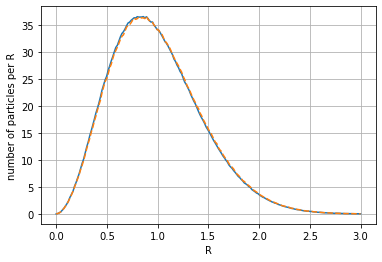

In [20]:
fig = plt.figure()
plt.plot(bins, densityNonInteracting)
plt.plot(bins, densityInteracting, "--")
plt.xlabel("R")
plt.ylabel("number of particles per R")
plt.grid()
plt.show()
fig.savefig("figures/density10.pdf", bbox_inches = "tight")

### 50 particles

In [51]:
conf = src.config()
cutoff = 2000

conf["directory"] = "elliptical_50_interacting"
conf["threads"] = 12

conf["numPart"] = 50
conf["numDim"] = 3
conf["numSteps"] = 2**16 + cutoff
conf["stepLength"] = 0.5
conf["importanceSampling"] = 1

conf["alpha"] = 0.49759058979214105
conf["a"] = 0.0043

conf["InitialState"] = "HardshellInitial"
conf["Wavefunction"] = "EllipticalHardshellWavefunction"
conf["Hamiltonian"] = "EllipticalOscillator"

In [101]:
mu = 0.0003

for i in range(7):
    src.runner(conf)
    localEnergies, _, psiGrad, acceptanceRate = src.readData(conf, cutoff)
    gradient = src.calculateGradient(localEnergies, psiGrad)
    conf["alpha"] -= mu*gradient
    print(f"gradient: {gradient:.5f}. alpha: {conf['alpha']:.5f}. acceptance rate: {acceptanceRate[0]:.5f}.")

KeyboardInterrupt: 

#### Using optimal alpha

In [52]:
conf["alpha"] = 0.4921689823406644
src.runner(conf, verbose = True)

Starting simulation
numPart: 50
numDim: 3
numSteps: 67536
stepLength: 0.5
importanceSampling: 1
alpha: 0.4921689823406644
a: 0.0043
omega: 1
InitialState: HardshellInitial
WaveFunction: EllipticalHardshellWavefunction
Hamiltonian: EllipticalOscillator
Done!
------------


In [53]:
localEnergies, _, psiGrad, acceptanceRate = src.readData(conf, cutoff, readPos = False)
localEnergies = np.concatenate(localEnergies)

bins = np.linspace(0, 3, 200)
densityInteracting = src.densityParallel(conf, bins)//conf["numSteps"]

100%|██████████| 3376800/3376800 [00:04<00:00, 779640.15it/s]


In [54]:
conf["directory"] = "elliptical_50_noninteracting"
conf["alpha"] = 0.4921689823406644
conf["a"] = 0

In [ ]:
src.runner(conf, verbose = True)

Starting simulation
numPart: 50
numDim: 3
numSteps: 67536
stepLength: 0.5
importanceSampling: 1
alpha: 0.4921689823406644
a: 0
omega: 1
InitialState: HardshellInitial
WaveFunction: EllipticalHardshellWavefunction
Hamiltonian: EllipticalOscillator


In [45]:
bins = np.linspace(0, 3, 200)
densityNonInteracting = src.densityParallel(conf, bins)/conf["numSteps"]

100%|██████████| 304800/304800 [00:00<00:00, 698290.44it/s]


[9.06787693e-02 0.00000000e+00 0.00000000e+00 7.70769539e-01
 7.01853675e-01 9.06787693e-01 2.05568770e+00 2.44560641e+00
 2.04027231e+00 4.28910579e+00 4.52033665e+00 4.12588400e+00
 7.13007163e+00 9.16490322e+00 8.16108924e+00 1.05033219e+01
 1.12777185e+01 1.29389536e+01 1.27059092e+01 1.32064560e+01
 1.36272055e+01 1.58062163e+01 1.48468349e+01 2.28038969e+01
 2.12605443e+01 2.43028170e+01 2.29562372e+01 2.30233395e+01
 2.25445556e+01 2.36263533e+01 2.79925361e+01 2.91305546e+01
 2.87750939e+01 3.31367427e+01 3.23260745e+01 3.57292487e+01
 3.83498651e+01 3.08806549e+01 3.71229814e+01 4.32428915e+01
 4.17648276e+01 4.12189414e+01 4.03892306e+01 3.89991251e+01
 4.51117809e+01 4.22082468e+01 4.24866306e+01 4.68591608e+01
 4.21620006e+01 4.38250492e+01 4.40236357e+01 5.11319444e+01
 4.60403315e+01 4.30814833e+01 4.56087006e+01 4.14329433e+01
 4.57592274e+01 4.42176883e+01 4.74104878e+01 4.55552001e+01
 4.39982457e+01 4.47472523e+01 4.58916184e+01 4.57755495e+01
 4.14256890e+01 4.209217

#### Estimation of energy and uncertainty

In [11]:
E = np.mean(localEnergies)
Var = src.blocking(localEnergies, 18)

100%|██████████| 18/18 [00:25<00:00,  1.41s/it]


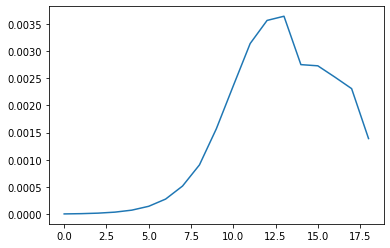

In [12]:
plt.plot(Var)
plt.show()

In [13]:
print(f"<E> = {E} +- {np.sqrt(Var[13])}")

<E> = 127.24753702249534 +- 0.06031441113864823


#### Radial onebody density

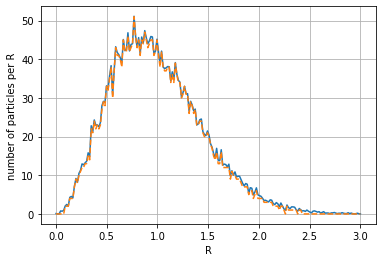

In [48]:
fig = plt.figure()
plt.plot(bins, densityNonInteracting)
plt.plot(bins, densityInteracting, "--")
plt.xlabel("R")
plt.ylabel("number of particles per R")
plt.grid()
plt.show()
fig.savefig("figures/density50.pdf", bbox_inches = "tight")